In [1]:
from gensim.models import Word2Vec

In [2]:
%time model = Word2Vec.load("word2vecBM2.model")

Wall time: 737 ms


In [3]:
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 34393


In [4]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
#os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

Using TensorFlow backend.


In [5]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [6]:
# reading data
df = pd.read_excel('WSD_Dictionary.xlsx')
#df = df.dropna()
#df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['Sense_Index'])))
print('No. of tokens',df['Sense_Example'].apply(lambda x: len(x.split(' '))).sum())

Shape of dataset  (408, 4)
Index(['Words', 'Sense_Index', 'Sense_Description', 'Sense_Example'], dtype='object')
No. of unique classes 408
No. of tokens 3543


In [7]:
macronum=sorted(set(df['Sense_Index']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['Sense_Index'].apply(fun)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
Words                408 non-null object
Sense_Index          408 non-null object
Sense_Description    104 non-null object
Sense_Example        408 non-null object
class                408 non-null int64
dtypes: int64(1), object(4)
memory usage: 16.0+ KB


In [9]:
texts = []
labels = []

for idx in range(df.Sense_Example.shape[0]):
    #text = BeautifulSoup(df.Sense_Example[idx],"lxml")
    text = df.Sense_Example[idx]
    texts.append(clean_str(text))

for idx in df['class']:
    labels.append(idx)

In [ ]:
texts

In [10]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 1364


In [12]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (408, 1000)
Shape of Label Tensor: (408, 408)


In [13]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    except:
        pass

In [15]:
#embedding_matrix
print("embedding_matrix ndim: ", embedding_matrix.ndim)
print("embedding_matrix shape:", embedding_matrix.shape)
print("embedding_matrix size: ", embedding_matrix.size)

embedding_matrix ndim:  2
embedding_matrix shape: (1365, 100)
embedding_matrix size:  136500


In [16]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [17]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(macronum), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         136500    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_1 (Dense)              (None, 408)               82008     
Total params: 379,308
Trainable params: 379,308
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp=ModelCheckpoint('model_lstm.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
%time history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=20, batch_size=2, callbacks=[cp])

Train on 327 samples, validate on 81 samples
Epoch 1/20
327/327 [==============================] - 111s 340ms/step - loss: 6.1486 - acc: 0.0000e+00 - val_loss: 6.0831 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to model_lstm.hdf5
Epoch 2/20
327/327 [==============================] - 99s 302ms/step - loss: 6.0796 - acc: 0.0000e+00 - val_loss: 6.1306 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/20
327/327 [==============================] - 99s 303ms/step - loss: 6.0265 - acc: 0.0000e+00 - val_loss: 6.1948 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/20
327/327 [==============================] - 99s 303ms/step - loss: 6.0002 - acc: 0.0000e+00 - val_loss: 6.2483 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/20
327/327 [==============================] - 99s 304ms/step - loss: 5.8995 - acc: 0.0000e+00 - val_loss: 6.4344 - val_acc: 0.0000e+00



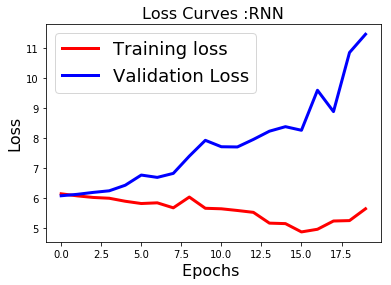

In [19]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :RNN',fontsize=16)
fig1.savefig('loss_rnn.png')
plt.show()

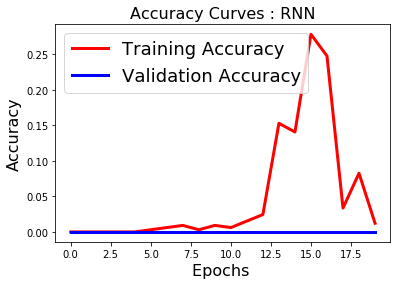

In [20]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : RNN',fontsize=16)
fig2.savefig('accuracy_rnn.png')
plt.show()

In [21]:
score = model.evaluate(x_val, y_val,
                       batch_size=2, verbose=1)
print('Test accuracy:', score[1])

81/81 [==============================] - 4s 49ms/step
Test accuracy: 0.0
